# **GAN Model Training**

# importing libraries

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

# Data set Loading

In [44]:
# Load the MNIST dataset, which contains 60,000 training images of handwritten digits.
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape the images to have an extra dimension for the color channel (for grayscale, this is 1).
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the pixel values from 0-255 to a range of -1 to 1. This helps the generator's tanh activation.
train_images = (train_images - 127.5) / 127.5

# Define the buffer size for shuffling the dataset.
BUFFER_SIZE = 60000

# Define the number of images to process in each training iteration.
BATCH_SIZE = 256

# Create a TensorFlow dataset from the images, shuffle it, and batch it.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#  Build the Generator Model

In [45]:
def make_generator_model():
    model = Sequential()

    # This layer takes the 100-dimensional random noise and expands it.
    # It will produce 7x7x256 values.
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))

    # Normalizes the outputs of the previous layer, which helps stabilize training.
    model.add(tf.keras.layers.BatchNormalization())

    # An activation function that introduces non-linearity.
    model.add(LeakyReLU())

    # Reshapes the flat output into a 3D tensor, like a tiny image.
    model.add(Reshape((7, 7, 256)))

    # Upsamples the image from 7x7 to 14x14.
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(LeakyReLU())

    # Further upsamples the image from 14x14 to the final 28x28 size.
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(LeakyReLU())

    # The final layer. It outputs a 28x28 grayscale image.
    # The 'tanh' activation function ensures pixel values are in the [-1, 1] range.
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Build the Discriminator Model

In [46]:
def make_discriminator_model():
    model = Sequential()

    # Flattens the 28x28 image into a single 1D array for processing by dense layers.
    model.add(Flatten(input_shape=(28, 28, 1)))

    # A fully connected layer with 128 neurons.
    model.add(Dense(128))
    model.add(LeakyReLU())

    # Randomly sets a fraction of neurons to zero during training to prevent overfitting.
    model.add(Dropout(0.3))

    # Another dense layer with fewer neurons.
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # The output layer with a single neuron. Its output value determines if the image is real (positive) or fake (negative).
    model.add(Dense(1))
    return model

# Define Loss Functions and Optimizers

In [47]:
# Use Binary Cross-Entropy, a standard loss function for binary classification (real vs. fake).
# 'from_logits=True' means the activation function is included in the loss calculation.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Calculates the discriminator's total loss. It's a combination of its loss on real images and fake images.
def discriminator_loss(real_output, fake_output):
    # Loss for real images: how close the discriminator's output is to 1 (real).
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Loss for fake images: how close the discriminator's output is to 0 (fake).
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # The total loss is the sum of the real and fake losses.
    total_loss = real_loss + fake_loss
    return total_loss

# Calculates the generator's loss. It wants the fake images to be classified as real.
def generator_loss(fake_output):
    # The generator's loss is how close the discriminator's output for fake images is to 1.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Defines the optimizers, which are the algorithms that adjust the models' weights.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the Training Step

In [48]:
# Decorator that compiles the function into a highly efficient TensorFlow graph.
@tf.function
def train_step(images):
    # Generate random noise that will be the input to the generator.
    noise = tf.random.normal([BATCH_SIZE, 100])

    # Use GradientTape to automatically calculate the gradients of the loss with respect to the model's weights.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generate fake images using the generator.
      generated_images = generator(noise, training=True)

      # Classify the real and fake images using the discriminator.
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # Calculate the loss for both models.
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate the gradients for each model.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to update the models' weights using their respective optimizers.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# The Training Loop and Helper Functions

In [52]:
# A helper function to generate a grid of images and save it.
def generate_and_save_images(model, epoch, test_input=tf.random.normal([16, 100])):
    # Make a prediction with the generator.
    predictions = model(test_input, training=False)

    # Create a plot to display the images.
    fig = plt.figure(figsize=(4, 4))

    # Loop through the 16 images and add them to the plot.
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Rescale the pixels back to 0-255 for display.
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # Save the generated plot as a PNG file.
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

    # Display the plot.
    plt.show()

# The main training loop.
def train(dataset, epochs):
    # Loop for each epoch.
    for epoch in range(epochs):
        # Loop through each batch of images in the dataset.
        for image_batch in dataset:
            # Run one training step for the current batch.
            train_step(image_batch)

        # Print the current epoch number to the console.
        print (f'Epoch {epoch + 1} done.')

    # After all epochs are finished, generate and save the final images.
    generate_and_save_images(generator, epochs)

# Putting It All Together: Run the Training

Epoch 1 done.


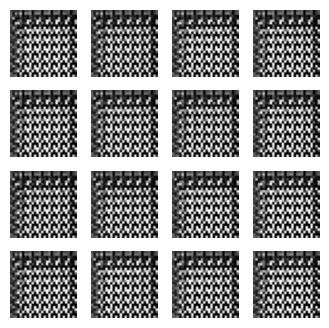

In [56]:
# Create instances of the generator and discriminator models.
generator = make_generator_model()
discriminator = make_discriminator_model()

# Set the number of epochs (full passes through the dataset) for training.
EPOCHS = 1

# Call the train function to start the training process.
train(train_dataset, EPOCHS, )